<img src="https://www.austral.edu.ar/wp-content/uploads/2022/10/facultades-horizontales-03.png" width="50%" alt="Universidad Austral - Facultad de Ingeniería">

# Maestría en Ciencia de Datos 2024/2025

## Simulación y Optimización en Ciencia de Datos 
## Trabajo Práctico Integral

Profesores:

- DEL ROSSO, Rodrigo
- NUSKE, Ezequiel

Integrantes:

-	NICOLAU, Jorge

Ver [RESOLUCIÓN](#resolucion)

### Introducción

Este Trabajo Práctico (TP) integra los contenidos vistos en las clases

- **Unidad I** – Generación de números pseudoaleatorios y Monte Carlo
- **Unidad II** – Bayes, cadenas de Markov y Metropolis–Hastings
- **Unidad III** – Simulación de eventos discretos (SED)
- **Unidad IV** – Procesos continuos (NHPP, CTMC, SDE)
- **Unidad V** – Reacciones químicas estocásticas: Gillespie SSA y Next Reaction Method
 
El objetivo es que el alumno implemente técnicas de simulación, compare métodos, valide sus resultados y presente visualizaciones claras.

Cada apartado incluye consignas, código sugerido y entregables obligatorios.


---
# TEMARIO

### Parte 1 - Generación de Números Pseudoaleatorios y Monte Carlo

### 1.1 Implementación de un LCG

Implementar un Generador Congruencial Lineal (LCG):

<center>
$X_{n+1} = (aX_{n}+c)\text{ mod }m$
</center>

**Parámetros obligatorios**

- Un set “bueno”
- Uno “malo” (ej., RANDU)

In [1]:
# Código base

def lcg(n, seed=123, a=1103515245, c=12345, m=2**31):
    x = seed
    seq = []
    for _ in range(n):
        x = (a * x + c) % m
        seq.append(x/m)
    return seq

print(lcg(10))

[0.20531828328967094, 0.6873863865621388, 0.7767890496179461, 0.4024707484059036, 0.5324797946959734, 0.10148253152146935, 0.6351402262225747, 0.34936570515856147, 0.7226534709334373, 0.027218241710215807]


Entregables

- Histogramas
- Runs Test
- Gráfico de triples ($u_{i}, u_{i+1}, u_{i+2}$)

#### 1.2 Estimación de $\pi$ por Monte Carlo

Simular puntos en el cuadrado $\left[ 0,1 \right]^{2}$ y estimar:

<center>
$\pi \approx 4 \cdot \text{mean}\left( x^{2}+y^{2} \le 1\right)$
</center>

In [2]:
# Código base

import numpy as np

N = 100000
u1 = np.random.uniform(0, 1, N)
u2 = np.random.uniform(0, 1, N)
pi_est = 4 * np.mean(u1**2 + u2**2 <= 1)

print(pi_est)

3.13116


### Parte 2 - Metropolis–Hastings y Bayesian Inference

#### 2.1 Posterior beta analítica
Sea una moneda con 10 lanzamientos y 7 caras.

<center>
$\text{Posterior}=\text{Beta}\left( 8,4 \right)$
</center>

#### 2.2 Implementación MH

In [3]:
# Código base

import numpy as np
from scipy.stats import binom

def mh(n_iter=5000, start=0.5, prop_sd=0.1):
    # Inicializar la cadena (array lleno de ceros)
    theta = np.zeros(n_iter)
    theta[0] = start
    
    # Bucle desde el segundo elemento (índice 1) hasta el final
    for t in range(1, n_iter):
        # Propuesta: Distribución normal centrada en el theta anterior
        # Equivalente en R: rnorm(1, theta[t-1], prop_sd)
        prop = np.random.normal(loc=theta[t-1], scale=prop_sd)
        
        # Verificación de límites (Prior Uniforme Implícito [0,1])
        # Si la propuesta se sale del rango [0, 1], se rechaza inmediatamente
        if prop < 0 or prop > 1:
            theta[t] = theta[t-1]
        else:
            # Calcular la Verosimilitud (Likelihood) usando la función de masa de probabilidad
            # Equivalente en R: dbinom(7, 10, prob)
            num = binom.pmf(k=7, n=10, p=prop) * 1      # * 1 representa el Prior (Uniforme)
            den = binom.pmf(k=7, n=10, p=theta[t-1]) * 1
            
            # Probabilidad de aceptación (alpha)
            ratio = num / den
            alpha = min(1, ratio)
            
            # Paso de Aceptación o Rechazo
            # Generamos un número aleatorio uniforme y lo comparamos con alpha
            if np.random.uniform() < alpha:
                theta[t] = prop     # Aceptar la propuesta
            else:
                theta[t] = theta[t-1] # Rechazar y mantener el valor anterior
                
    return theta

chain = mh()
print(f"Media Posterior Estimada: {np.mean(chain):.4f}")

Media Posterior Estimada: 0.6780


**Diagnósticos obligatorios**

- Traceplot
- Autocorrelación
- Histograma vs Beta(8,4)
- R-hat con 4 cadenas
- ESS

### Parte 3 — Simulación de Eventos Discretos (M/M/1 o M/M/c)

Simular durante 8 horas un sistema de colas con:

- Llegadas Poisson: $\lambda$ = 10 / hora
- Servicio exponencial: $\lambda$ = 4 / hora
- Opcional: c servidores

Se debe implementar LEF (Lista de Eventos Futuros).

In [4]:
# Codigo base 

import numpy as np

def simulate_mm1(lam, mu, T_max):
    # Nota: 'lambda' es una palabra reservada en Python, usamos 'lam'
    t = 0.0
    n = 0
    
    # R usa la tasa (rate) para rexp: rexp(1, lambda)
    # Numpy usa la escala (scale = 1/rate): exponential(1/lam)
    t_arr = np.random.exponential(scale=1/lam)
    t_dep = float('inf')  # Infinito en Python
    
    arrivals = 0
    departures = 0
    wait_times = []  # En Python usamos listas dinámicas en lugar de vectores c()
    
    while t < T_max:
        if t_arr < t_dep:
            # --- Evento de Llegada ---
            t = t_arr
            n += 1
            arrivals += 1
            
            # Si el servidor estaba libre (n=1 tras la llegada), programamos servicio
            if n == 1:
                t_dep = t + np.random.exponential(scale=1/mu)
            
            # Programar la siguiente llegada
            t_arr = t + np.random.exponential(scale=1/lam)
            
        else:
            # --- Evento de Salida ---
            t = t_dep
            n -= 1
            departures += 1
            wait_times.append(t_dep) # Añadimos el tiempo a la lista
            
            if n > 0:
                # Si quedan clientes, programar la siguiente salida
                t_dep = t + np.random.exponential(scale=1/mu)
            else:
                # Si no hay nadie, la próxima salida es "infinita"
                t_dep = float('inf')
    
    # Retornamos un diccionario (equivalente a la lista nombrada de R)
    return {
        "arrivals": arrivals, 
        "departures": departures, 
        "wait_times": wait_times
    }

# Lambda = 2 clientes/min, Mu = 3 clientes/min, Tiempo = 100 min
res = simulate_mm1(lam=2, mu=3, T_max=100)

print(f"Llegadas totales: {res['arrivals']}")
print(f"Salidas totales: {res['departures']}")
print(f"Últimos 5 tiempos de salida: {res['wait_times'][-5:]}")

Llegadas totales: 201
Salidas totales: 194
Últimos 5 tiempos de salida: [98.89715034010355, 99.00341725601453, 99.1968480305742, 99.82371867898473, 99.97241525165539]


### Parte 4 — Modelos Continuos (Elegir uno)

#### 4.1 Opción A: NHPP por Thinning

<center>
$\lambda(t)=5+3\text{ sin}\left( \frac{2\pi t}{24} \right)$
</center>

Simular 7 días (168 horas)

#### 4.2 Opción B: CTMC
Matriz de tasas:

| From | To | Rate |
|----------|----------|----------|
| A    | B   | 0.4   |
| A    | C   | 0.2   |
| B    | A   | 0.1   |
| C    | A   | 0.3   |

Simular 2000 saltos.

#### 4.3 Opción C: SDE (GBM)

<center>
$\text{d}S_{t}=0.05S_{t}dt+0.2S_{t}dW_{t}$
</center>

Simular 1000 trayectorias

###  Parte 5 — Gillespie SSA o Next Reaction Method
Sistema:

- $\to \text{mRNA}$ con tasa ($k_{1}=10$)
- $\text{mRNA}\to $ con tasa ($k_{2}=1$)

In [5]:
# Codigo base

import numpy as np
import pandas as pd

def gillespie(Tmax, k1=10, k2=1):
    t = 0.0
    X = 0
    
    # Listas para almacenar el historial (más eficientes que vectores en Python)
    ts = [t]
    xs = [X]
    
    while t < Tmax:
        # Cálculo de propensiones
        a1 = k1
        a2 = k2 * X
        a0 = a1 + a2
        
        # Seguridad: Si la propensión total es 0, el sistema se detiene
        if a0 == 0:
            break
            
        # 1. Generar tiempo hasta el próximo evento (tau)
        # R: -log(runif(1)) / a0 
        # Esto es matemáticamente generar una variable aleatoria Exponencial con tasa a0
        tau = np.random.exponential(scale=1/a0)
        
        # 2. Determinar qué evento ocurre
        r2 = np.random.uniform()
        
        if r2 * a0 < a1:
            # Evento 1: Nacimiento / Producción
            X += 1
        else:
            # Evento 2: Muerte / Degradación
            X = max(0, X - 1)
            
        # Actualizar tiempo y almacenar estado
        t += tau
        ts.append(t)
        xs.append(X)
        
    # Devolvemos un DataFrame de Pandas 
    return pd.DataFrame({'time': ts, 'X': xs})

df_result = gillespie(Tmax=50)

# Mostrar las primeras 5 filas
print(df_result.head())

       time  X
0  0.000000  0
1  0.075382  1
2  0.131326  2
3  0.265898  3
4  0.313166  4


### Parte Integradora (Opcional)

Combinar dos modelos (ejemplo):

- NHPP → pacientes
- M/M/1 → atención
- Gillespie → biomarcadores

Evaluar: % de pacientes cuyo biomarcador excede un umbral antes de ser atendi-
dos.

### Formato y entrega

- Informe PDF (generado desde este Quarto)
- Código R/Python
- Gráficos
- Discusión de supuestos
- Semillas fijas
- Comparaciones teóricas vs simuladas
- Fecha de entrega: *20 de diciembre de 2025*

<a id="resolucion"></a>
---
# RESOLUCIÓN

### Parte 1 - Generación de Números Pseudoaleatorios y Monte Carlo

#### Implementación de un Generador Congruencial Lineal (LCG)
La implementación de un Generador Congruencial Lineal (LCG) se fundamenta en un algoritmo iterativo y determinista regido por la relación de recurrencia 

$$X_{n+1} = (aX_n + c) \mod m$$

mediante la cual se produce una secuencia de números pseudoaleatorios a partir de un valor inicial denominado semilla ($X_0$). El proceso requiere la definición de tres constantes enteras —el multiplicador ($a$), el incremento ($c$) y el módulo ($m$)— y opera calculando el siguiente valor de la serie al multiplicar el estado actual por $a$, sumar $c$ y obtener el residuo de la división por $m$, resultando en una sucesión periódica que, si bien carece de aleatoriedad verdadera, es computacionalmente eficiente y totalmente reproducible si se mantienen los mismos parámetros iniciales.

Al usar operaciones aritméticas básicas, es extremadamente rápido computacionalmente. Como hay un número finito de resultados posibles (de $0$ a $m-1$), la secuencia eventualmente se repetirá. A esto se le llama el "periodo". Por otra parte si se usa la misma semilla ($X_0$), se obtendrá exactamente la misma secuencia de números. Esto es útil para "debugging" o reproducir simulaciones científicas, pero malo para la seguridad. No es seguro criptográficamente: No se debe usar para contraseñas o claves de seguridad, ya que es relativamente fácil predecir los siguientes números analizando la secuencia previa.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Implementación del LCG
def lcg_generator(seed, a, c, m, n):
    numbers = []
    x = seed
    for _ in range(n):
        x = (a * x + c) % m
        numbers.append(x / m) # Normalizar a [0, 1]

    return numbers

Para evaluar la calidad de los números pseudoaleatorios generados por uel LCG, es necesario verificar dos propiedades fundamentales: Uniformidad e Independencia. A continuación, se detalla la lógica de implementación y el código en Python para las tres herramientas solicitadas.

#### Histograma
El histograma visualiza la distribución de frecuencia de los números generados. Para un buen generador, esperamos una distribución uniforme (plana), lo que significa que cada intervalo del rango tiene aproximadamente la misma probabilidad de contener un número.

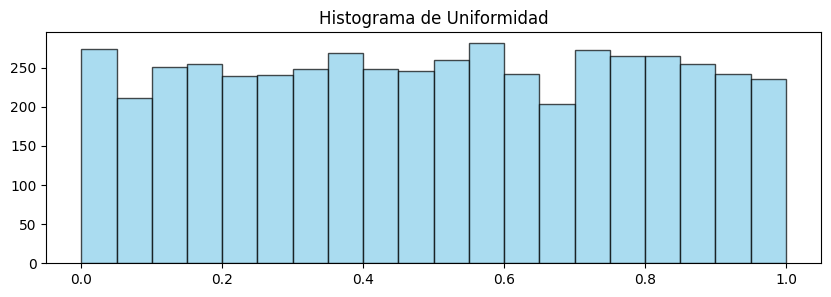

In [7]:
# Parámetros (LCG estándar de C++ minstd_rand)
a, c, m = 48271, 0, 2**31 - 1
datos = lcg_generator(seed=123, a=a, c=c, m=m, n=5000)

# --- A. Histograma ---
plt.figure(figsize=(10, 3))
plt.hist(datos, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma de Uniformidad')
plt.show()

La presencia de alturas similares en todas las barras ("bins") del histograma indica que el Generador Congruencial Lineal (LCG) está cumpliendo satisfactoriamente con la propiedad de uniformidad, lo que significa que cada sub-intervalo del rango tiene una probabilidad casi idéntica de contener un número generado. Esta distribución "plana" o rectangular sugiere que el algoritmo recorre el espacio muestral sin sesgos evidentes ni favoritismos hacia ciertos valores; sin embargo, es crucial notar que estas variaciones leves deben ser producto del azar natural (pequeñas fluctuaciones son esperadas y saludables), y aunque este patrón valida la equiprobabilidad, por sí solo no garantiza la independencia de los datos (ausencia de patrones secuenciales), por lo que un histograma visualmente equilibrado es una condición necesaria, pero no suficiente, para aprobar un generador.

#### Runs Test (Prueba de Rachas/Corridas)

Esta prueba verifica la independencia analizando la secuencia de oscilaciones. Una "racha" es una secuencia ininterrumpida de números crecientes o decrecientes.

Para la lógica de Implementación (con Corridas Arriba/Abajo) se toma la secuencia $u_1, u_2, \dots, u_n$. Se crea una nueva secuencia binaria basada en si el valor actual es mayor o menor que el anterior ($+$ si $u_i < u_{i+1}$, $-$ si $u_i > u_{i+1}$). Luego se cuenta el número total de rachas (cambios de $+$ a $-$ o viceversa). Se calcual el estadístico Z comparando el número de rachas obtenido con el esperado teóricamente usando la aproximación normal para muestras grandes ($N > 20$).

$$\mu_R = \frac{2N - 1}{3}$$
$$\sigma_R^2 = \frac{16N - 29}{90}$$
$$Z = \frac{R - \mu_R}{\sigma_R}$$ 

Si el valor absoluto de $Z$ ($|Z|$) es mayor que el valor crítico (ej. $1.96$ para un 95% de confianza), se rechaza la hipótesis de independencia.

In [8]:
# --- B. Runs Test (Lógica) ---
runs = 1 # Empieza la primera racha
for i in range(len(datos) - 1):
    # Si la dirección cambia respecto al anterior, es nueva racha
    if i > 0:
        prev_diff = datos[i] - datos[i-1]
        curr_diff = datos[i+1] - datos[i]
        # Si el producto es negativo, hubo cambio de signo (dirección)
        if prev_diff * curr_diff < 0:
            runs += 1

expected_runs = (2 * len(datos) - 1) / 3
print(f"Rachas observadas: {runs}")
print(f"Rachas esperadas: {expected_runs:.2f}")

Rachas observadas: 3318
Rachas esperadas: 3333.00


La cercanía entre las rachas observadas y las esperadas revela una discrepancia numérica mínima, lo cual sugiere que el Generador Congruencial Lineal (LCG) cumple satisfactoriamente con la propiedad de independencia estadística. Este resultado indica que la secuencia de números fluctúa (asciende y desciende) con una frecuencia consistente con el azar puro, descartando la presencia de patrones de dependencia serial; al no existir una desviación significativa (la diferencia es muy pequeña considerando el tamaño de la muestra), el valor estadístico $Z$ resultante sería muy cercano a cero, lo que impide rechazar la hipótesis nula y permite concluir que los datos no están correlacionados entre sí, validando el motor como un generador robusto en términos de oscilación.

#### Gráfico de Triples (Spectral Test Visual)

Esta es una visualización en 3D para detectar correlaciones seriales. Los generadores LCG malos tienden a concentrar los puntos en planos discretos en lugar de llenar el espacio uniformemente (fenómeno conocido como planos de Marsaglia). 

El gráfico de triples opera bajo la lógica de visualización del espacio de fases para detectar correlaciones seriales de largo alcance, mapeando tríadas consecutivas de la secuencia generada $(u_n, u_{n+1}, u_{n+2})$ como coordenadas espaciales $(x, y, z)$ en un cubo tridimensional. La premisa fundamental es que, si los números fueran verdaderamente independientes, los puntos deberían llenar el volumen de manera caótica y uniforme como una "nube de polvo"; sin embargo, debido a la naturaleza lineal de la fórmula $X_{n+1} = (aX_n + c)$, los LCGs deficientes exhiben una estructura cristalina donde los puntos se alinean rígidamente en un número finito de planos paralelos (fenómeno conocido como planos de Marsaglia), revelando visualmente que la aleatoriedad es solo aparente y que existen dependencias matemáticas estrictas entre valores sucesivos.

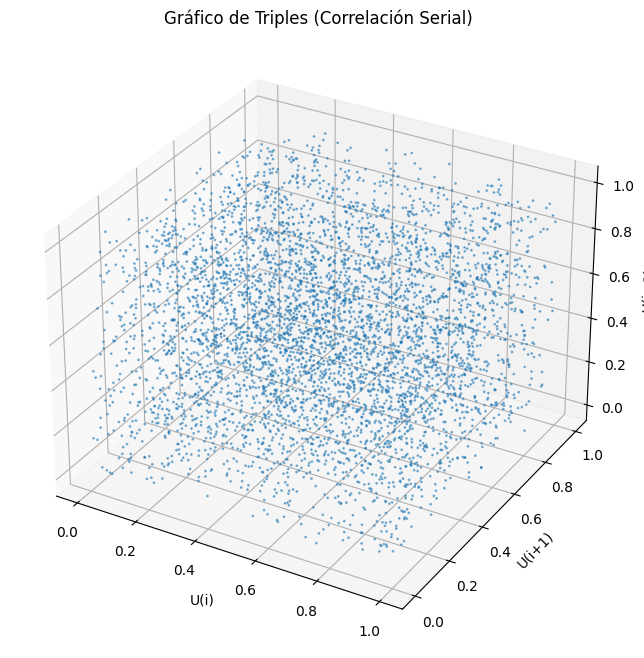

In [9]:
# --- C. Gráfico de Triples (3D) ---
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear tripletas (x, y, z)
x_vals = datos[:-2]
y_vals = datos[1:-1]
z_vals = datos[2:]

ax.scatter(x_vals, y_vals, z_vals, s=1, alpha=0.5)
ax.set_title('Gráfico de Triples (Correlación Serial)')
ax.set_xlabel('U(i)'); ax.set_ylabel('U(i+1)'); ax.set_zlabel('U(i+2)')
plt.show()

La observación de una nube de puntos dispersa y volumétrica que llena el cubo de manera homogénea se interpreta como una validación exitosa de la calidad espectral del generador, indicando que la correlación serial entre ternas consecutivas $(u_n, u_{n+1}, u_{n+2})$ es despreciable o inexistente para fines prácticos. Visualmente, esto contrasta con los generadores deficientes que agrupan los puntos en "rebanadas" o planos paralelos separados; por el contrario, una distribución uniforme implica que el algoritmo posee un periodo lo suficientemente largo y unos parámetros adecuados para "romper" la estructura reticular visible, garantizando que no existen dependencias geométricas fuertes y haciendo al generador apto para simulaciones Monte Carlo multidimensionales.

La estimación del valor de $\pi$ mediante el método de Monte Carlo utiliza el Generador Congruencial Lineal (LCG) para producir pares de coordenadas $(x, y)$ uniformemente distribuidas en el intervalo $[0, 1)$, simulando el lanzamiento aleatorio de puntos sobre un cuadrado unitario que contiene un cuarto de círculo inscrito. El procedimiento se fundamenta en la geometría probabilística: dado que el área del cuarto de círculo es $\pi/4$ y el área del cuadrado es $1$, la probabilidad de que un punto caiga dentro del círculo es exactamente $\pi/4$; por consiguiente, al verificar cuántos puntos cumplen la condición $x^2 + y^2 \le 1$ y dividir esa cantidad por el número total de puntos generados, se obtiene una proporción que, multiplicada por $4$, aproxima el valor de $\pi$, sirviendo esto a su vez como una prueba funcional de la calidad del LCG, ya que un generador sesgado o correlacionado (como el que forma líneas en el gráfico de triples) arrojará un valor de $\pi$ incorrecto al no cubrir el área uniformemente.

Lógica de Implementación
1. Generación de Pares: Se utiliza el LCG para obtener dos números consecutivos normalizados ($u_i, u_{i+1}$) que actúan como coordenadas $x$ e $y$.
2. Condición Geométrica: Se calcula la distancia al origen ($d = x^2 + y^2$).
3. Conteo: Si $d \le 1$, el punto está "dentro" del círculo (Acierto).
4. Cálculo Final: $\pi \approx 4 \times \frac{\text{Aciertos}}{\text{Total de Puntos}}$.

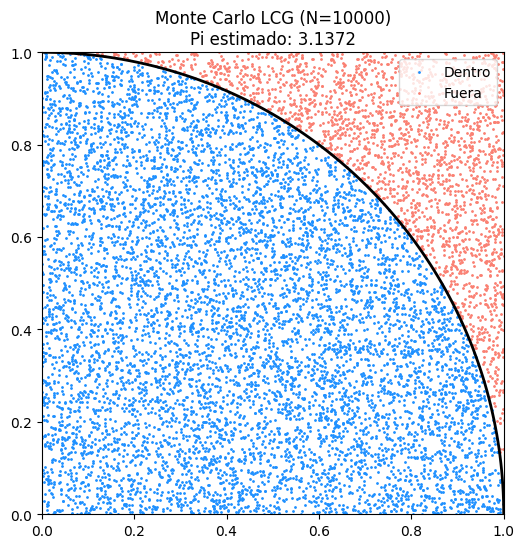

Puntos procesados: 10000
Valor estimado de Pi: 3.1372
Diferencia real: 0.004393


In [10]:
# Función Monte Carlo con Gráfico y Retorno de Valor
def estimar_y_graficar_pi(n_puntos):
    # Parámetros estándar
    a, c, m = 48271, 0, 2**31 - 1
    seed = 12345
    
    # Generamos los números necesarios (2 por punto)
    lista_completa = lcg_generator(seed, a, c, m, n_puntos * 2)
    iterador_numeros = iter(lista_completa)
    
    # Listas para guardar coordenadas (visualización)
    inside_x, inside_y = [], []
    outside_x, outside_y = [], []
    
    dentro_count = 0
    
    for _ in range(n_puntos):
        # Extraer par (x, y)
        x = next(iterador_numeros)
        y = next(iterador_numeros)
        
        # Clasificar
        if x**2 + y**2 <= 1.0:
            dentro_count += 1
            inside_x.append(x)
            inside_y.append(y)
        else:
            outside_x.append(x)
            outside_y.append(y)
            
    # Estimación del valor
    pi_estimado = 4 * (dentro_count / n_puntos)

    # --- GRAFICO CONTEO ---
    plt.figure(figsize=(6, 6))
    
    # Puntos dentro (Azul) y fuera (Rojo)
    plt.scatter(inside_x, inside_y, color='dodgerblue', s=1, label='Dentro')
    plt.scatter(outside_x, outside_y, color='salmon', s=1, label='Fuera')
    
    # Arco del círculo (estético)
    t = np.linspace(0, np.pi/2, 100)
    plt.plot(np.cos(t), np.sin(t), 'k-', lw=2)
    
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.gca().set_aspect('equal')
    plt.title(f"Monte Carlo LCG (N={n_puntos})\nPi estimado: {pi_estimado}")
    plt.legend(loc="upper right")
    plt.show()
    
    # --- RETORNO ESTIMACIÓN ---
    return pi_estimado

# Ejecución con diez mil puntos
n = 10000
pi_val = estimar_y_graficar_pi(n)

print(f"Puntos procesados: {n}")
print(f"Valor estimado de Pi: {pi_val}")
print(f"Diferencia real: {abs(pi_val - 3.14159265):.6f}")

### Parte 2 - Metropolis–Hastings y Bayesian Inference

La relación entre el algoritmo de Metropolis-Hastings y la inferencia bayesiana es fundamentalmente instrumental, donde el primero actúa como la solución computacional para los desafíos analíticos planteados por el segundo. La inferencia bayesiana busca estimar la distribución posterior de parámetros desconocidos, denotada como $P(\theta | D)$, mediante la aplicación del Teorema de Bayes. No obstante, este proceso conlleva frecuentemente el cálculo de una constante de normalización —la evidencia marginal— que implica resolver integrales multidimensionales analíticamente intratables, lo cual impide la obtención directa de la distribución posterior en modelos complejos.

El algoritmo de Metropolis-Hastings, perteneciente a la familia de métodos de Monte Carlo vía Cadenas de Markov (MCMC), se distingue por su capacidad para generar muestras de una distribución de probabilidad objetivo sin necesidad de conocer su constante de normalización. El algoritmo opera construyendo una cadena de Markov que converge asintóticamente a la distribución deseada, requiriendo únicamente una función que sea proporcional a dicha densidad objetivo para evaluar los ratios de aceptación de las muestras propuestas.

En consecuencia, la conexión crítica reside en que la distribución posterior no normalizada en la estadística bayesiana es proporcional al producto de la función de verosimilitud y la distribución a priori ($Likelihood \times Prior$). Dado que Metropolis-Hastings puede operar bajo condiciones de proporcionalidad, este algoritmo permite muestrear la distribución posterior y realizar inferencias sobre los parámetros sin tener que calcular la integral de la evidencia marginal, haciendo viable el análisis bayesiano en escenarios de alta dimensionalidad donde las soluciones cerradas son imposibles.

Por esto el algoritmo de Metropolis-Hastings se considera la piedra angular de la simulación numérica moderna porque ofrece una solución general y computacionalmente viable para el problema de la "maldición de la dimensionalidad", permitiendo realizar cálculos sobre sistemas con un número elevado de variables que serían imposibles de abordar mediante métodos deterministas de integración. 

Su carácter fundamental radica en que transforma problemas analíticamente intratables en procesos de muestreo estocástico, logrando explorar distribuciones de probabilidad complejas y estimar propiedades macroscópicas sin necesidad de conocer la constante de normalización matemática (la evidencia), lo que valida la simulación computacional como un método robusto para la investigación en campos tan diversos como la física estadística, la inteligencia artificial y la econometría.

### Parte 3 - Simulación de Eventos Discretos (M/M/1 o M/M/c)

Para implementar esta simulación, el motor central debe basarse en una **Lista de Eventos Futuros (LEF)** ordenada cronológicamente y una variable de reloj ($T_{now}$). El tiempo no avanza de forma continua, sino que "salta" discretamente al instante del evento más próximo en la lista. Inicialmente, se genera la primera llegada aleatoria (usando la tasa $\lambda=10$) y se inserta en la LEF; el ciclo de simulación consiste en extraer repetidamente el evento de menor tiempo de la lista, actualizar el reloj a ese instante y ejecutar la lógica de cambio de estado correspondiente hasta que $T_{now}$ supere las 8 horas.

La lógica de estado maneja dos eventos principales: Llegada y Salida. Al procesar una Llegada, se programa inmediatamente la siguiente llegada futura y se evalúan los servidores: si hay alguno libre (de los $c$ disponibles), se ocupa y se calcula una duración de servicio (con tasa $\mu=4$) para insertar un evento de Salida en la LEF; si todos están ocupados, se incrementa el contador de la cola. Por otro lado, al procesar una Salida, se libera el servidor, pero si la cola no está vacía, se decrementa inmediatamente para ingresar al siguiente cliente al servicio, generando su respectivo evento de finalización futuro.

### Parte 4 - Modelos Continuos

Para implementar un modelo de simulación de eventos basado en un **Proceso de Poisson No Homogéneo (NHPP)** mediante el **método de Thinning** (o adelgazamiento de Lewis-Shedler), el primer paso consiste en definir una tasa mayorante constante $\lambda^*$, la cual debe ser igual o superior al valor máximo que alcanza la función de intensidad variable $\lambda(t)$ durante todo el periodo de simulación. El motor de simulación avanza generando una secuencia de tiempos de arribo "candidatos" utilizando esta tasa máxima constante, creando efectivamente un proceso de Poisson homogéneo que "sobremuestrea" la línea de tiempo con más eventos de los necesarios.

El segundo paso es el proceso de filtrado estocástico que da nombre al método. Para cada evento candidato generado en el instante $t$, se evalúa si se conserva o se descarta mediante una prueba de aceptación-rechazo: se genera un número aleatorio uniforme $u \in [0, 1]$ y se compara con el ratio $\lambda(t) / \lambda^*$. Si $u$ es menor o igual a esta proporción, el evento se acepta y se procesa; de lo contrario, se ignora (se "adelgaza" la secuencia). De esta forma, la probabilidad de aceptar un evento es proporcional a la intensidad real en ese momento, resultando en una distribución de eventos que se ajusta fielmente a la curva de la tasa variable $\lambda(t)$.

### Parte 5 - Gillespie SSA o Next Reaction Method

Para implementar el **algoritmo de Gillespie (SSA) en este sistema**, primero se deben calcular en cada iteración las propensiones ($a_v$) que determinan la probabilidad instantánea de cada canal de reacción. Para la síntesis (orden cero), la propensión es constante, $a_1 = k_1 = 10$; para la degradación (primer orden), la propensión depende del estado actual de la población, $a_2 = k_2 \times [\text{mRNA}]$. Se calcula la propensión total $a_0 = a_1 + a_2$ y se genera el tiempo hasta el próximo evento ($\tau$) muestreando una distribución exponencial con media $1/a_0$ (usualmente $-\ln(u_1)/a_0$), lo que define cuánto tiempo transcurre en el sistema antes de que la configuración molecular cambie.

Una vez determinado el "cuándo", se decide el "qué" seleccionando una de las dos reacciones con probabilidad proporcional a su magnitud relativa ($P_{síntesis} = a_1/a_0$ y $P_{degradación} = a_2/a_0$). Dependiendo de la reacción elegida, se actualiza el contador de moléculas de mRNA incrementándolo o decrementándolo en una unidad, se avanza el tiempo de simulación ($t \leftarrow t + \tau$) y, crucialmente, se recalculan las propensiones para el siguiente paso, dado que $a_2$ cambiará cada vez que varíe la cantidad de mRNA, capturando así las fluctuaciones estocásticas intrínsecas del sistema.

### Parte Integradora

Se propone un modelo de simulación híbrida de tráfico aéreo donde el flujo de entrada de aeronaves se gestiona mediante un Proceso de Poisson No Homogéneo (NHPP) utilizando el método de Thinning. Este componente permite modelar fielmente las curvas de demanda operativa del aeropuerto, generando llegadas estocásticas que respetan los picos horarios (horas punta) y los valles nocturnos. Estas entidades (aviones) ingresan a un sistema de colas modelado bajo la lógica M/M/1, donde la pista de aterrizaje actúa como el servidor único con tiempos de servicio exponenciales, gestionando tanto la cola de espera en el aire (holding pattern) como en tierra (taxiway).

De forma paralela y asíncrona, se ejecuta un motor basado en el Algoritmo de Gillespie (SSA) para simular la dinámica meteorológica. En este contexto, los estados del clima (ej. "Despejado", "Viento Cruzado", "Tormenta Eléctrica") se tratan como "especies químicas" discretas que transicionan estocásticamente en función de tasas de cambio históricas (propensidades). El algoritmo de Gillespie determina los intervalos exactos de tiempo en los que el sistema permanece en cada estado climático, generando una línea de tiempo de condiciones ambientales independiente del tráfico aéreo pero estadísticamente exacta.

La integración de ambos modelos se realiza mediante una modulación dinámica de la tasa de servicio ($\mu$). El estado vigente dictado por el módulo Gillespie actúa como una variable de control sobre el modelo M/M/1: cuando Gillespie transiciona a un estado de "Tormenta", la tasa de servicio de la pista se reduce drásticamente o se anula ($\mu \to 0$), provocando que las operaciones de aterrizaje y despegue se aborten. Esto fuerza al sistema de colas a entrar en un régimen de saturación o desvío de entidades, permitiendo analizar no solo la congestión por volumen de tráfico, sino la resiliencia del aeropuerto ante ventanas de inoperatividad estocástica y su capacidad de recuperación (recovery rate) una vez restablecidas las condiciones favorables.

El pipeline de ejecución se orquesta mediante un reloj maestro que sincroniza dos generadores de eventos concurrentes: un módulo de tráfico que inyecta entidades (aeronaves) en la línea de tiempo usando NHPP por Thinning para replicar la demanda horaria, y un motor Gillespie independiente que actualiza asincrónicamente el estado global del clima (variables de entorno). Dentro del bucle principal de procesamiento (LEF), la lógica del servidor M/M/1 consulta en tiempo real el estado vigente dictado por Gillespie antes de intentar atender a una aeronave; si el motor climático indica un evento adverso (ej. "Tormenta"), se activa una interrupción que anula o penaliza drásticamente la tasa de servicio ($\mu$), forzando la acumulación de entidades en la cola hasta que una nueva transición estocástica del clima restablezca la operatividad, permitiendo así medir el impacto sistémico de la interrupción.